In [1]:
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
import numpy as np

In [2]:
plt.style.use('dark_background')

In [3]:
stock_tags = ['ACGL',
              'ADM',
              'AFL',
              'ALL',
             'ALXN',
              'ANTM',
              'BBL',
              'BHP',
#             'BLK',
#              'BNS',
#              'BSBR',
#              'BTI',
#             'CB',
#              'CBRE',
#              'CI',
#              'CINF',
#             'DAL',
#              'DGX',
#              'DHI',
#              'EC',
#              'EQR',
#             'ESS',
#              'FITB',
#              'FMX',
#              'FOXA',
#             'FTV',
#              'GD',
#              'GOLD',
#              'HIG',
#             'INFO',
#              'JCI',
#              'L',
#              'LH',
#              'LHX',
#             'MAA'
             ]

In [203]:
def get_graph(stock_name, start_load, end_load, start_fib, end_fib):
    #stock_name is the stock symbol
    #start_load is the date you start loading data from
    #end_load is the dat you end loading data from
    #start_fib is the begining date you start looking for max and mins for when doing fibonacci retracement
    #end_fib is the begining date you start looking for max and mis for when doing fibonacci retracement
    
    #getting the stock data into a dataframe
    df = web.DataReader(stock_name, data_source = 'yahoo', start = start_load, end = end_load)

    #Pringint the starting and ending values of the dataframe
    print('Starting: ' + str(df['Open'][0]))
    print('Ending:   ' + str(df['Open'][len(df)-1]))
    
    #plotting the actual stock data COMMENT NEXT LINE IF YOU WANT TO REMOVE ACTUAL STOCK DATA
    df['Open'].plot(figsize=(16,6), color='blue')
    #Taking a rolling mean of 10 for trend lines
    df_average = df['Open'].rolling(10).mean()
    #plotting this rolling mean of the data  COMMENT NEXT LINE IF YOU WANT TO REMOVE ROLLING MEAN
    df_average.plot(figsize=(16,6), color='cyan')
    
    #creating new dataframe for trendlines
    df_trend = df['Open'].copy()
    #clearing dataframe except for initial and final values, which are points on the trend line
    for i in range(1,len(df_trend)-1):
        df_trend[i]=0
    
    #plotting the edges of the region in which fibonacci retracement max and mins are searched for
    plt.axhline(y=(np.max(df['Open'][start_fib:end_fib])), color='r')
    plt.axhline(y=(np.min(df['Open'][start_fib:end_fib])), color='r')

    #finding the stock minimum in the given region
    stock_min = np.min(df['Open'][start_fib:end_fib])
    
    #finding the range between the maximum and minimum in the given region
    stock_range = np.max(df['Open'][start_fib:end_fib] - np.min(df['Open'][start_fib:end_fib]))
    
    #trnd_dst is the trend distance, a variable that measures how far measurments will be take to find changes in stock direction
    trnd_dst = round(len(df_average)/40)

    #i is the initial point from which we will look to find trend lines
    i=10
    while i < len(df_average)-(trnd_dst*2):
        #go through every point and see if the difference in distance from it the points around it, trnd_dst away is large
        #if it is large enough and crosses a certain threshhold (stock_range*.1), we can create a new trend line for the region
        if abs((df_average[i]-df_average[i+trnd_dst])-(df_average[i+trnd_dst]-df_average[i+(trnd_dst*2)])) > stock_range*.1:
            #plt.axvline(x=df_average.index[i+trnd_dst], color='g')
            #plt.axvline(x=df_average.index[i+(trnd_dst*2)], color='r')
            
            #adding the new trend change to our dataframe
            df_trend[i] = df_average[i]

            i+=(trnd_dst*2)
        else:
            i+=1
            
    #clear all points that aren't 0, ie make dataframe only contain days where trend lines change
    df_trend = df_trend[df_trend > 0]
    #plot the trend lines COMMENT NEXT LINE IF YOU WANT TO GET RID OF TREND LINES
    plt.plot(df_trend, color='w')
    
    #mid represents the different fibonacci retracement levels in proportion to the min and max of our given region
    mid = {
        stock_range * .236 + stock_min,
        stock_range * .382 + stock_min,
        stock_range * .500 + stock_min,
        stock_range * .618 + stock_min,
        stock_range * .786 + stock_min
            }
    
    for fib_line in mid:
        #plot each fibonacci retracement level
        plt.axhline(y=fib_line, color='g')
    
    #Represents the number of times the stock reverses near the retracement, rather than passing through
    num_reversals = 0

    #for each value of our stock, check if it is relative to the stock value, close to a fibonacci retracement line
    #if it is, check if the values to its left and right indicate if it crosses the line, or reverses direction
    #if it does, mark a vertical line there as a possible indicator of a resistance or support level
    #do this for all retracement lines, and break the loop if a reversal is found
    for i in range(5,len(df)-5):
        for fib_pos in mid:
            dist = df['Open'][i]-fib_pos
            dist_left = df['Open'][i-3]-fib_pos
            dist_right = df['Open'][i+3]-fib_pos
    
            if abs(dist) < stock_range*.02 and (dist-dist_right)*(dist-dist_left)>0:
                plt.axvline(x=df.index[i], color='y')
                num_reversals+=1
                break
    
    #Count the number of days your data spans
    num_days = (df.index[len(df)-1]-df.index[0]).days
    #Print the number of days your data spans
    print('Days:     ' + str(num_days))
    
    df_values = df_trend[:len(df_trend)-1].copy()
    df_dates = df_trend[:len(df_trend)-1].copy()
    for i in range(len(df_trend)-1):
        #df_return['Days Since'][i] = (df_return.index[i]-df_trend.index[0]).days
        df_values[i] = (df_trend[i+1]/df_trend[i] -1) * (num_days/((df_trend.index[i+1]-df_trend.index[i]).days+2))
        df_dates[i] =  (df_trend.index[i]-df_trend.index[0]).days
    
    #Plot the regions in which fibonacci retracement is performed
    plt.axvline(x=start_fib, color='w')
    plt.axvline(x=end_fib, color='w')
    
    plt.show()
    
    return df['Open'][0], num_days, df_values, df_dates
    

In [267]:
def get_monte(initial, numSteps, values, dates, numSims, lowPercentile, highPercentile):
    #initial is the initial value of the stock from the starting day data was collected from
    #numSteps is the number of days the monte carlo simulation will last (normally range of collected stock data)
    #values is the list of different data trends for the stock
    #dates is the list of days where the trend goes from one value to the next
    #numSims is the number of Monte Carlo Simulations you want to perform
    #lowPercentile is the lower percentile whose value you want to measure
    #highPercentile is the higher percentile whose value you want to measure
    
    #volatility is an array measuring the stock volatility over the whole time period
    volatility = np.ndarray(shape=(numSteps))
    
    #for each of the values in the array, set them to a certain volatility (can be modified to take real stock volatility)
    for i in range(0,numSteps):
        if i < 50:
            volatility[i] = .2
        elif i < 60:
            volatility[i] = .2
        else:
            volatility[i] = .2

    #stockReturn is an array that represents the stock volatility over the whole time period
    stockReturn = np.ndarray(shape=(numSteps))
    
    #for each of the values in the array, set them to the return calculated from our analysis given values and dates
    for i in range(0,numSteps):
        
        for j in range(1,len(dates)):
            if i <= dates[j]:
                stockReturn[i] = values[j-1]
                break
            elif i > dates[len(dates)-1]:
                stockReturn[i] = values[len(values)-1]
            
    #array of calculated values of the monte carlo simulation
    y = np.ndarray(shape=(numSteps,numSims), dtype=float)

    #an array that holds a modified version of the y array that has greater stock variability
    y_non_rolling = np.ndarray(shape=(numSteps, numSims), dtype=float)

    #perform the monte carlo simulation
    for j in range(0,numSims):
        y[0][j]=initial
        y_non_rolling[0][j] = initial
        for i in range(1,numSteps):
            y[i][j] = y[i-1][j] + (y[i-1][j] * ((stockReturn[i]/numSteps)+((volatility[i]/50) * np.random.normal())))
            #y_non_rolling[i][j] = y[i][j] + (y[i][j] * volatility[i]/2.5 * np.random.normal())
        
    #plot the monte carlo simulation
    plt.figure(figsize=(16, 6))
    plt.suptitle('Monte Carlo: ' + str(numSims) + ' Lines, ' + str(numSteps) + ' Steps, ' + str(volatility[0]*100) +
                 '% init. volatility')
    plt.xlabel ('Time Step')
    plt.ylabel ('Asset Price')
    plt.xlim(-numSteps/100,numSteps+numSteps/100)
    
    #plt.plot(y_non_rolling)
    plt.plot(y)
    #plt.savefig('MonteCarlo.png', dpi=500)
    plt.show()
    
    #plot a histogram of the final position of the array ie the final values
    plt.hist(y[len(y)-1], bins='auto')
    #plt.savefig('Histogram.png', dpi=500)
    plt.show()
    
    #print relevant statistics
    print("Mean:   " + str(np.mean(y[numSteps-1])))
    print("Median: " + str(np.median(y[numSteps-1])))
    print(str(lowPercentile) + "%ile: " + str(np.percentile(y[numSteps-1], lowPercentile)))
    print(str(highPercentile) + "%ile: " + str(np.percentile(y[numSteps-1], highPercentile)))
    

In [268]:
def analyze_and_monte(stock_name, start_load, end_load, start_fib, end_fib, numSims, lowPercentile, highPercentile):
    
    
    print("Stock Analysis (" + stock_name + "): \n")
    
    #perform analysis on the stock and display al relevant data, while pulling everything we need for monte carlo
    initial, numDays, df_values, df_dates = get_graph(stock_name, start_load, end_load, start_fib, end_fib)
    
    print("\nMonte Carlo Simulation: \n")
    
    #perform the monte carlo and also display relevant statistics
    get_monte(initial, numDays, df_values, df_dates, numSims, lowPercentile, highPercentile)

Stock Analysis (AAPL): 

Starting: 174.27999877929688
Ending:   289.92999267578125
Days:     305


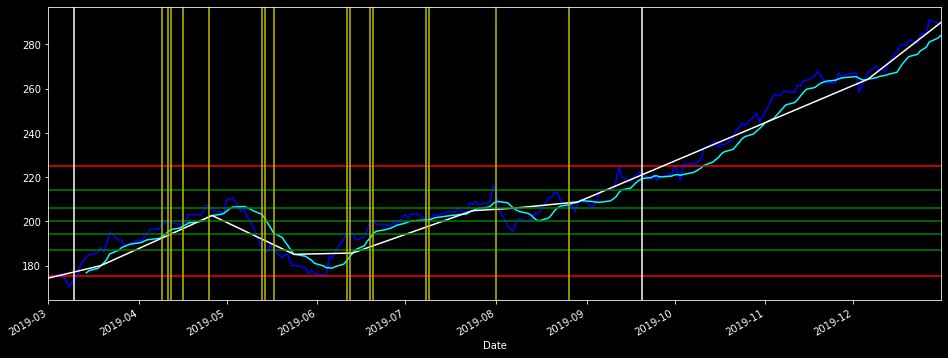


Monte Carlo Simulation: 



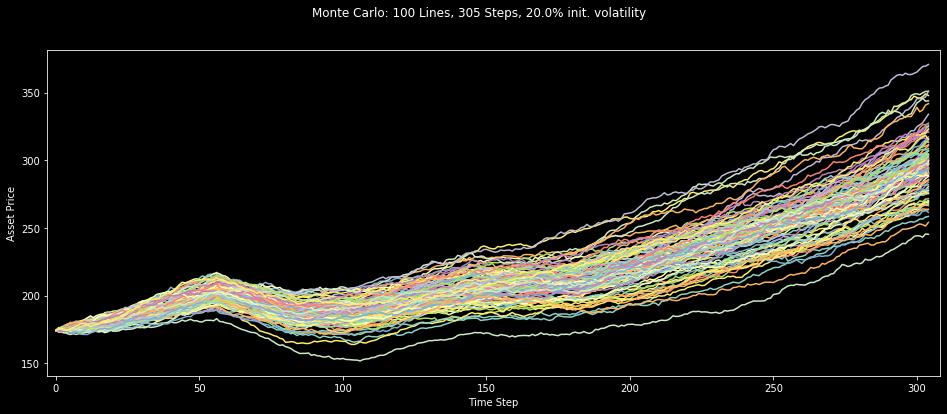

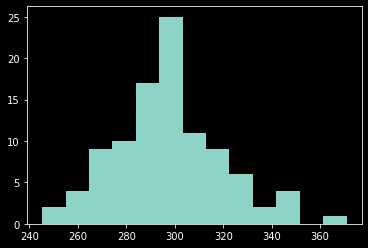

Mean:   297.5312043048752
Median: 297.0878279198871
25%ile: 284.80987705394386
75%ile: 307.80411649021494


In [272]:
#for stock in stock_tags:
analyze_and_monte('AAPL', '2019-3-1','2019-12-31','2019-3-10','2019-9-20', 100, 25, 75)